## MODEL

In [1]:
!pip install scikit-learn --upgrade

     |████████████████████████████████| 6.8MB 2.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

dir_drive = "/content/drive/My Drive/DSIM/data/"
dir_drive_model = "/content/drive/My Drive/DSIM/model/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import os
import numpy as np
from time import time

from scipy.io import wavfile as wav #import write
import librosa
import joblib #per salvare modelli svm

# Strumenti di classificazione
#from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
fs = 44000
n_mfcc = 15 
sampling_rate=44000 

In [5]:
# Segnaposto per feature extractor
def identity(input):  
    return input

def sdev(input):
    return np.std(input, keepdims=True)
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)
def spec_centroid(input):
    return librosa.feature.spectral_centroid(input)
def zcr(input):
    return np.mean(librosa.feature.zero_crossing_rate(input))

def mfcc(input, rate = fs, normalization = True):
    # Calcola coefficienti MFCC
    mfcc = np.mean(librosa.feature.mfcc(input, sr=rate, n_mfcc=15).T, axis=0)
    
    #mfcc = librosa.feature.mfcc(input, sr=rate, n_mfcc=15)
    #mfcc = scale(mfcc, axis=1)
    return mfcc

def combo(input):
    return np.concatenate((sdev(input), energy(input), mfcc(input)))

In [6]:
#misure non aggregate, per la rete ricorsiva 

def extr_feat(sound_clip):
  # Mel Frequency Cepstral Coefficents
  mfcc = librosa.feature.mfcc(y=sound_clip, sr=sampling_rate,n_mfcc=n_mfcc)
            
  # MFCC deltas
  mfcc_delta = librosa.feature.delta(mfcc)
  
  # MFCC double deltas
  mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
  
  mel_spectogram = librosa.feature.melspectrogram(y=sound_clip, sr=sampling_rate)
  # Root Mean Square Energy
  rmse = librosa.feature.rmse(S=mel_spectogram)
  
  mfcc = np.asarray(mfcc)
  mfcc_delta = np.asarray(mfcc_delta)
  mfcc_delta2 = np.asarray(mfcc_delta2)
  rmse = np.asarray(rmse)

  feature = np.concatenate((mfcc, mfcc_delta, mfcc_delta2, rmse), axis=0).T
  feature = np.asarray(feature)
  
  return feature

In [7]:
# Data loader
def load_data(feature_extractor=identity, normalize=False, test_size=0.1):
    labels = []
    features = []
    for f in sorted(os.listdir(dir_drive)):
        if f.endswith('.wav'):
            
            # Carica file ed estraine le features
            _, signal = wav.read(dir_drive + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)
            
            # Categorie
            label = f.split('_')[0]
            labels.append(label)
            
    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]
        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]
        result = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), X_train_mean, X_train_std
    else:
        result = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
    return result
# Main
if __name__ == '__main__':
	X_train, X_test, y_train, y_test = load_data()

In [8]:
X_train, X_test, y_train, y_test = load_data(feature_extractor = mfcc, normalize = False, test_size=0.2)
X_train_n, X_test_n, y_train_n, y_test_n, mean_train, std_train = load_data(feature_extractor = mfcc, normalize = True, test_size=0.2)

X_train_c, X_test_c, y_train_c, y_test_c = load_data(feature_extractor = combo, normalize = False, test_size=0.2)
X_train_cn, X_test_cn, y_train_cn, y_test_cn, mean_c, std_c = load_data(feature_extractor = combo, normalize = True, test_size=0.2)

X_train_en, X_test_en, y_train_en, y_test_en, mean_e, std_e = load_data(feature_extractor = extr_feat, normalize = True, test_size=0.2)
X_train_en, X_val_en, y_train_en, y_val_en = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# SVM

In [10]:
svm_estimator    = SVC(kernel = 'rbf', class_weight= 'balanced')
svm_estimator_n  = SVC(kernel = 'rbf', class_weight= 'balanced')
svm_estimator_c  = SVC(kernel = 'rbf', class_weight= 'balanced')
svm_estimator_cn = SVC(kernel = 'rbf', class_weight= 'balanced')

dataset_name1 = 'not_normalize_mfcc'
dataset_name2 = 'normalize_mfcc'
dataset_name3 = 'combo'
dataset_name4 = 'combo_normalize'

try:
    svm_estimator = joblib.load("/model/%s.pkl"%dataset_name1)
    print("using trained model")
except:
    print('building new model')
    svm_estimator.fit(X_train, y_train)
    joblib.dump(svm_estimator,dir_drive+"/model/%s.pkl"%dataset_name1)
    
try:
    svm_estimator_n = joblib.load("/model/%s.pkl"%dataset_name2)
    print("using trained model")
except:
    print('building new model')
    svm_estimator_n.fit(X_train_n, y_train_n)
    joblib.dump(svm_estimator_n,dir_drive+"/model/%s.pkl"%dataset_name2)

try:
    svm_estimator_c = joblib.load("/models/%s.pkl"%dataset_name3)
    print("using trained model")
except:
    print('building new model')
    svm_estimator_c.fit(X_train_c, y_train_c)
    joblib.dump(svm_estimator_c,dir_drive+"/model/%s.pkl"%dataset_name3)

try:
    svm_estimator_cn = joblib.load("/models/%s.pkl"%dataset_name4)
    print("using trained model")
except:
    print('building new model')
    svm_estimator_cn.fit(X_train_cn, y_train_cn)
    joblib.dump(svm_estimator_c,dir_drive+"/model/%s.pkl"%dataset_name4)


print('mfcc')
y_pred = svm_estimator.predict(X_test)
print(classification_report(y_test, y_pred))

print('mfcc normalize')
y_pred_n = svm_estimator_n.predict(X_test_n)
print(classification_report(y_test_n, y_pred_n))

print('combo')
y_pred_c = svm_estimator_c.predict(X_test_c)
print(classification_report(y_test_c, y_pred_c))

print('combo normalize')
y_pred_combo_n = svm_estimator_cn.predict(X_test_cn)
print(classification_report(y_test_cn, y_pred_combo_n))

#clf = SVC(kernel = 'rbf', class_weight= 'balanced')
#clf = clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

building new model
building new model
building new model
building new model
mfcc
              precision    recall  f1-score   support

       LIVIA       1.00      0.79      0.88        28
       chris       1.00      1.00      1.00        11
         rob       0.78      1.00      0.88        21

    accuracy                           0.90        60
   macro avg       0.93      0.93      0.92        60
weighted avg       0.92      0.90      0.90        60

mfcc normalize
              precision    recall  f1-score   support

       LIVIA       0.96      0.93      0.95        28
       chris       1.00      1.00      1.00        11
         rob       0.91      0.95      0.93        21

    accuracy                           0.95        60
   macro avg       0.96      0.96      0.96        60
weighted avg       0.95      0.95      0.95        60

combo
              precision    recall  f1-score   support

       LIVIA       1.00      0.54      0.70        28
       chris       1.00    

# NN

In [10]:
!pip install tqdm --upgrade
!pip install -U tensorflow-addons
!pip install parameter-sherpa

  Using cached https://files.pythonhosted.org/packages/28/7e/281edb5bc3274dfb894d90f4dbacfceaca381c2435ec6187a2c6f329aed7/tqdm-4.48.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b3/f8/d6fca180c123f2851035c4493690662ebdad0849a9059d56035434bff5c9/tensorflow_addons-0.11.2-cp36-cp36m-manylinux2010_x86_64.whl
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [11]:
#keras for modeling
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras            import Sequential, optimizers, regularizers
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils      import to_categorical
from tensorflow.keras.layers     import Dense, Dropout, LSTM, Input, Flatten
from tensorflow.keras.losses     import categorical_crossentropy
from tensorflow.keras.callbacks  import EarlyStopping

#plot
%matplotlib inline
import matplotlib.pyplot as plt

#utili
import sherpa                     # AutoML
import pandas as pd
import time
from sklearn import preprocessing # encoder label

In [12]:
import tensorflow_addons as tfa
import tqdm

tqdm_callback = tfa.callbacks.TQDMProgressBar(    
    leave_epoch_progress   = True,
    leave_overall_progress = True,
    show_epoch_progress    = False,
    show_overall_progress  = True
)

In [13]:
def plot_history(network_history, metrics, val=False):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    if val:
      plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.plot(network_history.history[metrics])
    if val:
      plt.plot(network_history.history['val_'+metrics])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

In [18]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
#list(le.classes_)
#print(le.transform(y_train))
#le.inverse_transform(le.transform(y_train))

LabelEncoder()

In [ ]:
Y_train = to_categorical(le.transform(y_train),3)
Y_val   = to_categorical(le.transform(y_val),3)
Y_test  = to_categorical(le.transform(y_test),3)

In [ ]:
model = Sequential([
              Dense(32,activation='relu',
                    input_shape = (17,)),
              Dropout(0.2),
              Dense(64,activation='relu',
                    input_shape = (17,)),
              Dropout(0.2),
              Dense(3,activation='softmax'),
          ])

model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])
model.summary()

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15)

In [ ]:
history = model.fit(
    X_train, Y_train, #batch_size=16,
    validation_data = (X_val, Y_val),
    epochs=300, verbose=0, callbacks=[tqdm_callback, early_stop]) 
#[best_model, early_stop]) 

In [ ]:
plot_history(history, 'accuracy', val = True)

In [19]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
# Report di classificazione
print("Report di classificazione modello:")
print(classification_report(y_test, le.inverse_transform(y_pred)))

NameError: ignored

In [ ]:
# Matrice di confusione
print("Matrice di confusione modello:")
labels = ['Livia', 'chirs', 'rob']
cm = confusion_matrix(y_test, le.inverse_transform(y_pred))
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.imshow(cm, cmap=plt.cm.Blues)

In [20]:
Y_train_en = to_categorical(le.transform(y_train_en),3)
Y_val_en   = to_categorical(le.transform(y_val_en),3)
Y_test_en  = to_categorical(le.transform(y_test_en),3)

In [ ]:
X_train_en.shape

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_en.shape[1],X_train_en.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(Flatten())
regressor.add(Dense(units=3, activation='softmax'))

regressor.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
regressor.summary()

In [ ]:
history2 = regressor.fit(X_train_en, Y_train_en, 
    validation_data = (X_val_en, Y_val_en),
    epochs=100, verbose=0, callbacks=[tqdm_callback, early_stop])

In [ ]:
plot_history(history2, 'categorical_accuracy', val=True)

In [ ]:
y_pred2 = np.argmax(regressor.predict(X_test_en), axis=-1)
# Report di classificazione
print("Report di classificazione modello:")
print(classification_report(y_test_en, le.inverse_transform(y_pred2)))

In [ ]:
parameters = [sherpa.Discrete('lstm_unit',[20,100]),
              sherpa.Discrete('hidden_unit',[8,126]),
              sherpa.Ordinal(name='batch_size', range=[12,32,64])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=25)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

def get_model_lstm_score(params, epochs=60):
   initial = Input(shape=((X_train_en.shape[1],X_train_en.shape[2])))

   OUTPUT_SIZE = 3

   x1 = LSTM(int(params['lstm_unit']), activation='tanh', 
           return_sequences=True,
           kernel_regularizer=regularizers.l1(0.001),
           activity_regularizer=regularizers.l1(0.001))(initial)

   x2 = LSTM(int(params['lstm_unit']), activation='tanh', 
           return_sequences=False,
           kernel_regularizer=regularizers.l1(0.001),
           activity_regularizer=regularizers.l1(0.001))(x1)
   x3 = Dense(int(params["hidden_unit"]), activation='relu')(x2)

   x4 = Dense(OUTPUT_SIZE, activation='softmax')(x3)

   model = Model(initial, x4)

   model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(), 
                metrics=['categorical_accuracy'])

   hist = model.fit(X_train_en, Y_train_en, validation_data=(X_val_en, Y_val_en),
            batch_size=int(params["batch_size"]), epochs=epochs,
            verbose=0, callbacks=[study.keras_callback(trial, objective_name='val_loss'),tqdm_callback, early_stop]) #study.keras_callback(trial, objective_name='val_loss')
    
   return model, model.evaluate(X_val_en, Y_val_en)[0], hist

best_score = 999999

for trial in study:
   start_time = time.time()
    
   model, score, hist = get_model_lstm_score(trial.parameters)

   if score < best_score:
     model.save(dir_drive_model + "best_model")
     best_model   = model
     best_score   = score
     best_history = hist
   else:
     del model #free RAM
     
   study.finalize(trial)
   if(trial.id % 10 == 0 or trial.id == 1):
       print("Trial:",trial.id, "|| Best Score: ", best_score)
   study.results.to_csv(dir_drive_model + "AutoML.csv")

In [14]:
best_model_1 = tf.keras.models.load_model(dir_drive_model + "best_model")
results = pd.read_csv(dir_drive_model + "AutoML.csv")
results = results[results["Status"]=="COMPLETED"]

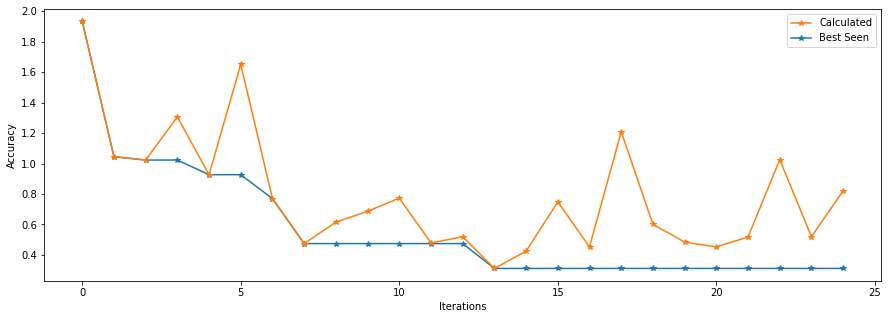

In [15]:
plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
actual, = plt.plot(np.array(results.Objective),'*-')

plt.legend([actual, best],
           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

In [26]:
y_pred_best = np.argmax(best_model_1.predict(X_test_en), axis=-1)
print("Report di classificazione modello:")
print(classification_report(y_test_en, le.inverse_transform(y_pred_best)))

#confusion_matrix(y_test_en, le.inverse_transform(y_pred_best))

Report di classificazione modello:
              precision    recall  f1-score   support

       LIVIA       1.00      1.00      1.00        28
       chris       1.00      1.00      1.00        11
         rob       1.00      1.00      1.00        21

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



# TEST

In [ ]:
test = sd.rec(int(duration * rec_rate), samplerate=rec_rate, channels=1, blocking=True)
wav.write('test.wav', rec_rate, test)

In [84]:
_, test = wav.read('test.wav')

In [91]:
feature = extr_feat(test)
feature = feature.reshape(1, feature.shape[0], feature.shape[1])

In [109]:
# feature = X_test_en[0].reshape(1, X_test_en.shape[1], X_test_en.shape[2]
prob_test_audio = best_model_1.predict(feature)

if max(prob_test_audio[0]) < 0.7:   
    predizione = 'sconosciuto'  
else:   
    predizione = le.inverse_transform([np.argmax(prob_test_audio)])

print(predizione)

['rob']


In [ ]:
dataset_name4 = 'combo_normalize'
svm_estimator_cn = joblib.load(dir_drive+"/model/%s.pkl"%dataset_name4)
svm_estimator_cn.predict(combo(test).reshape(1,-1))[0]